## Creating phantom for dMRI

In [1]:
import numpy as np, matplotlib.pyplot as plt

In [2]:
D_ECS   = 2.0e-3   # outside cell, free-ish water
D_CYTO  = 0.5e-3   # cytoplasm, medium
D_ORG   = 0.1e-3   # organelle, low
D_MEM   = 1e-8  # membrane, very low isotropic

# channels
D_CH_X  = (1.5e-3, 0.1e-3)  # channel 1: fast along x, slow along y
D_CH_Y  = (0.1e-3, 1.5e-3)  # channel 2: fast along y, slow along x

# fiber: fast vertically, slow horizontally
D_FIB   = (0.2e-3, 3e-3)  # (Dxx, Dyy)

In [3]:
N = 128

# inner cell box
x_cell0, x_cell1 = 16, 16 + 96  # [16, 112)
y_cell0, y_cell1 = 16, 16 + 96  # [16, 112)

In [4]:
# fiber
x_f0 = x_cell0 + 30           # 16 + 30 = 46
x_f1 = x_f0 + 8               # width ≈ 8 px (slender bar)
y_f0 = y_cell0 + 16           # 16 + 16 = 32
y_f1 = y_cell1 - 16           # 112 - 16 = 96   -> height = 64

In [5]:
# organelle
x_org1 = x_cell1 - 5          # right edge 5 px from cell border -> 112 - 5 = 107
x_org0 = x_org1 - 16          # width 16 -> 91
y_org0 = y_cell0 + 40         # 16 + 40 = 56
y_org1 = y_org0 + 16          # 72

In [6]:
ch_size = 5

y_ch1_0 = y_cell1 - 20 - ch_size   # 112 - 20 - 5 = 87
y_ch1_1 = y_ch1_0 + ch_size        # 92
x_ch1_0 = x_cell0 - 2              # extend 2 px outside cell
x_ch1_1 = x_ch1_0 + ch_size        # 3 px inside, 2 px outside

x_ch2_0 = x_cell0 + 20          # same x-position as before
x_ch2_1 = x_ch2_0 + ch_size     # width 5 px
y_ch2_0 = (y_cell1 - 1) - 2     # e.g. 111 - 2 = 109
y_ch2_1 = y_ch2_0 + ch_size     # 109..113

In [7]:
mem_top    = (y_cell0    , slice(x_cell0, x_cell1))
mem_bottom = (y_cell1-1  , slice(x_cell0, x_cell1))
mem_left   = (slice(y_cell0, y_cell1), x_cell0)
mem_right  = (slice(y_cell0, y_cell1), x_cell1-1)

In [8]:
src_x, src_y = 70, 90

In [9]:
N = 128
Dxx = np.full((N, N), D_ECS, dtype=float)
Dyy = np.full((N, N), D_ECS, dtype=float)

Y, X = np.mgrid[0:N, 0:N]

# --- cell interior: cytoplasm ---
inside_cell = (
    (X >= x_cell0) & (X < x_cell1) &
    (Y >= y_cell0) & (Y < y_cell1)
)
Dxx[inside_cell] = D_CYTO
Dyy[inside_cell] = D_CYTO

# --- membrane ring (1 px thick) ---
# top & bottom
Dxx[y_cell0, x_cell0:x_cell1] = D_MEM
Dyy[y_cell0, x_cell0:x_cell1] = D_MEM
Dxx[y_cell1-1, x_cell0:x_cell1] = D_MEM
Dyy[y_cell1-1, x_cell0:x_cell1] = D_MEM
# left & right
Dxx[y_cell0:y_cell1, x_cell0] = D_MEM
Dyy[y_cell0:y_cell1, x_cell0] = D_MEM
Dxx[y_cell0:y_cell1, x_cell1-1] = D_MEM
Dyy[y_cell0:y_cell1, x_cell1-1] = D_MEM

# --- channel 1 (fast along x) ---
mask_ch1 = (
    (X >= x_ch1_0) & (X < x_ch1_1) &
    (Y >= y_ch1_0) & (Y < y_ch1_1)
)
Dxx[mask_ch1] = D_CH_X[0]
Dyy[mask_ch1] = D_CH_X[1]

# --- channel 2 (fast along y) ---
mask_ch2 = (
    (X >= x_ch2_0) & (X < x_ch2_1) &
    (Y >= y_ch2_0) & (Y < y_ch2_1)
)
Dxx[mask_ch2] = D_CH_Y[0]       # slow along x
Dyy[mask_ch2] = D_CH_Y[1]       # fast along y

# --- fiber (anisotropic) ---
mask_fib = (
    (X >= x_f0) & (X < x_f1) &
    (Y >= y_f0) & (Y < y_f1)
)
Dxx[mask_fib] = D_FIB[0]
Dyy[mask_fib] = D_FIB[1]

# --- organelle (uniform low D) ---
mask_org = (
    (X >= x_org0) & (X < x_org1) &
    (Y >= y_org0) & (Y < y_org1)
)
Dxx[mask_org] = D_ORG
Dyy[mask_org] = D_ORG

In [10]:
c = np.zeros((N, N), dtype=float)
c[src_y, src_x] = 1.0   # point source at (70,90)

In [11]:
b = 1000.0  # toy value

D_eff_x = Dxx              # gradient direction g = (1,0)
D_eff_y = Dyy              # gradient direction g = (0,1)

S0 = np.ones((N, N))       # or some proton density mask

Sx = S0 * np.exp(-b * D_eff_x)
Sy = S0 * np.exp(-b * D_eff_y)

**Visualize phantom**

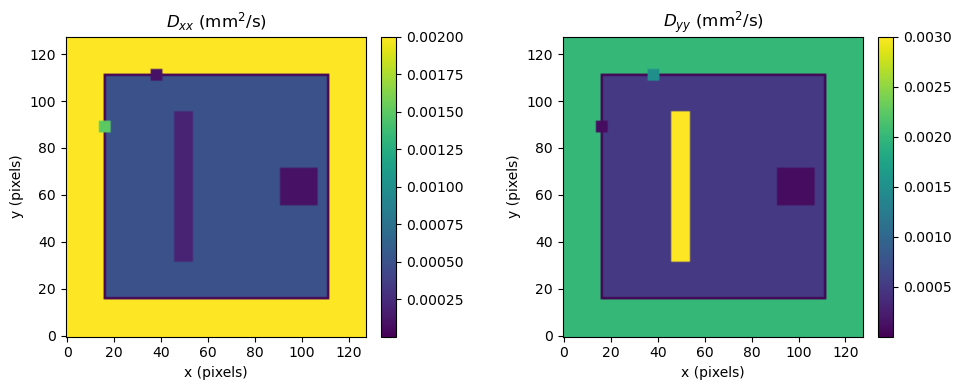

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

im0 = axs[0].imshow(Dxx, origin="lower")
axs[0].set_title(r"$D_{xx}$ (mm$^2$/s)")
axs[0].set_xlabel("x (pixels)")
axs[0].set_ylabel("y (pixels)")
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

im1 = axs[1].imshow(Dyy, origin="lower")
axs[1].set_title(r"$D_{yy}$ (mm$^2$/s)")
axs[1].set_xlabel("x (pixels)")
axs[1].set_ylabel("y (pixels)")
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

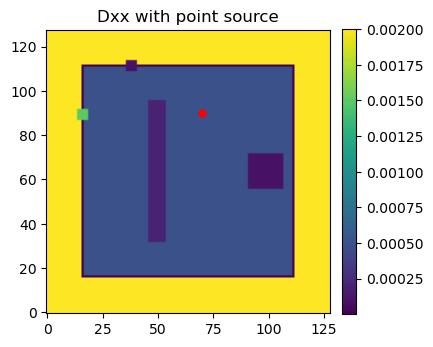

In [13]:
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(Dxx, origin="lower")
ax.plot(src_x, src_y, "ro", markersize=5)  # red dot for source
ax.set_title("Dxx with point source")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.show()

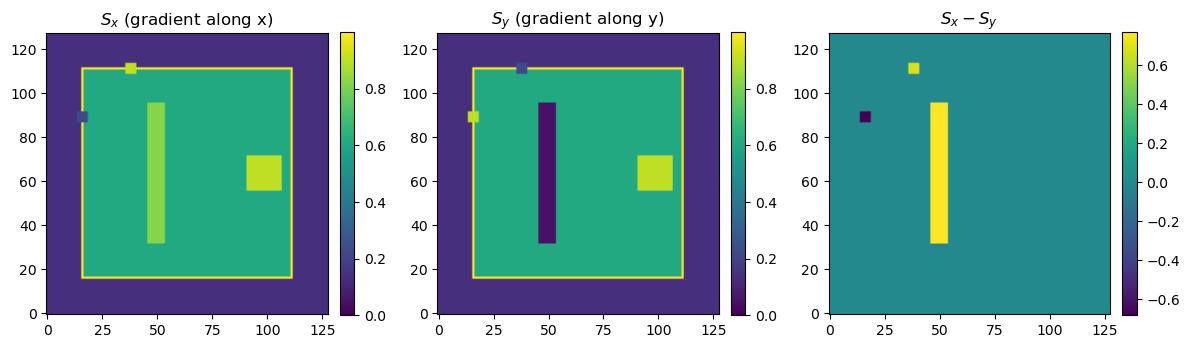

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

vmin = 0
vmax = max(Sx.max(), Sy.max())

im0 = axs[0].imshow(Sx, origin="lower", vmin=vmin, vmax=vmax)
axs[0].set_title(r"$S_x$ (gradient along x)")
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

im1 = axs[1].imshow(Sy, origin="lower", vmin=vmin, vmax=vmax)
axs[1].set_title(r"$S_y$ (gradient along y)")
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

# Optional: difference or ratio map
im2 = axs[2].imshow(Sx - Sy, origin="lower")
axs[2].set_title(r"$S_x - S_y$")
fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [15]:
# grid spacing (just 1 pixel units)
dx = dy = 1.0

# max diffusivity for stability estimate
Dmax = max(Dxx.max(), Dyy.max())

# time step (explicit scheme stability: dt <= 0.25 * min(dx^2,dy^2) / Dmax)
dt = 0.2 * dx**2 / Dmax   # a bit conservative

def diffusion_step(c, Dxx, Dyy, dt, dx=1.0, dy=1.0):
    """
    One explicit Euler step for
        ∂c/∂t = ∂x(Dxx ∂x c) + ∂y(Dyy ∂y c)
    with simple zero-flux (Neumann) boundaries.
    """
    c_new = c.copy()

    # interior values (shape: (N-2, N-2))
    cin = c[1:-1, 1:-1]

    # finite differences in x
    cx_plus  = (c[1:-1, 2:  ] - cin)            / dx   # c(i, j+1) - c(i, j)
    cx_minus = (cin            - c[1:-1, 0:-2]) / dx   # c(i, j)   - c(i, j-1)

    # finite differences in y
    cy_plus  = (c[2:  , 1:-1] - cin)            / dy   # c(i+1, j) - c(i, j)
    cy_minus = (cin            - c[0:-2, 1:-1]) / dy   # c(i, j)   - c(i-1, j)

    # divergence of flux: ∂x(Dxx ∂x c) + ∂y(Dyy ∂y c)
    div_x = (Dxx[1:-1, 2:  ] * cx_plus  - Dxx[1:-1, 1:-1] * cx_minus) / dx
    div_y = (Dyy[2:  , 1:-1] * cy_plus  - Dyy[1:-1, 1:-1] * cy_minus) / dy

    c_new[1:-1, 1:-1] = cin + dt * (div_x + div_y)

    # zero-flux BCs: copy neighbors at the edges
    c_new[0,  :]  = c_new[1,  :]
    c_new[-1, :]  = c_new[-2, :]
    c_new[:,  0]  = c_new[:,  1]
    c_new[:, -1]  = c_new[:, -2]

    return c_new

In [67]:
# initial condition: point source
c = np.zeros((N, N), dtype=float)
c[src_y, src_x] = 100.0

nsteps = 20000
snap_times = [0, 500, 2000, 5000, 6000, 7000, 10000, nsteps]
snaps = {}

for t in range(nsteps+1):
    if t in snap_times:
        snaps[t] = c.copy()
    c = diffusion_step(c, Dxx, Dyy, dt)

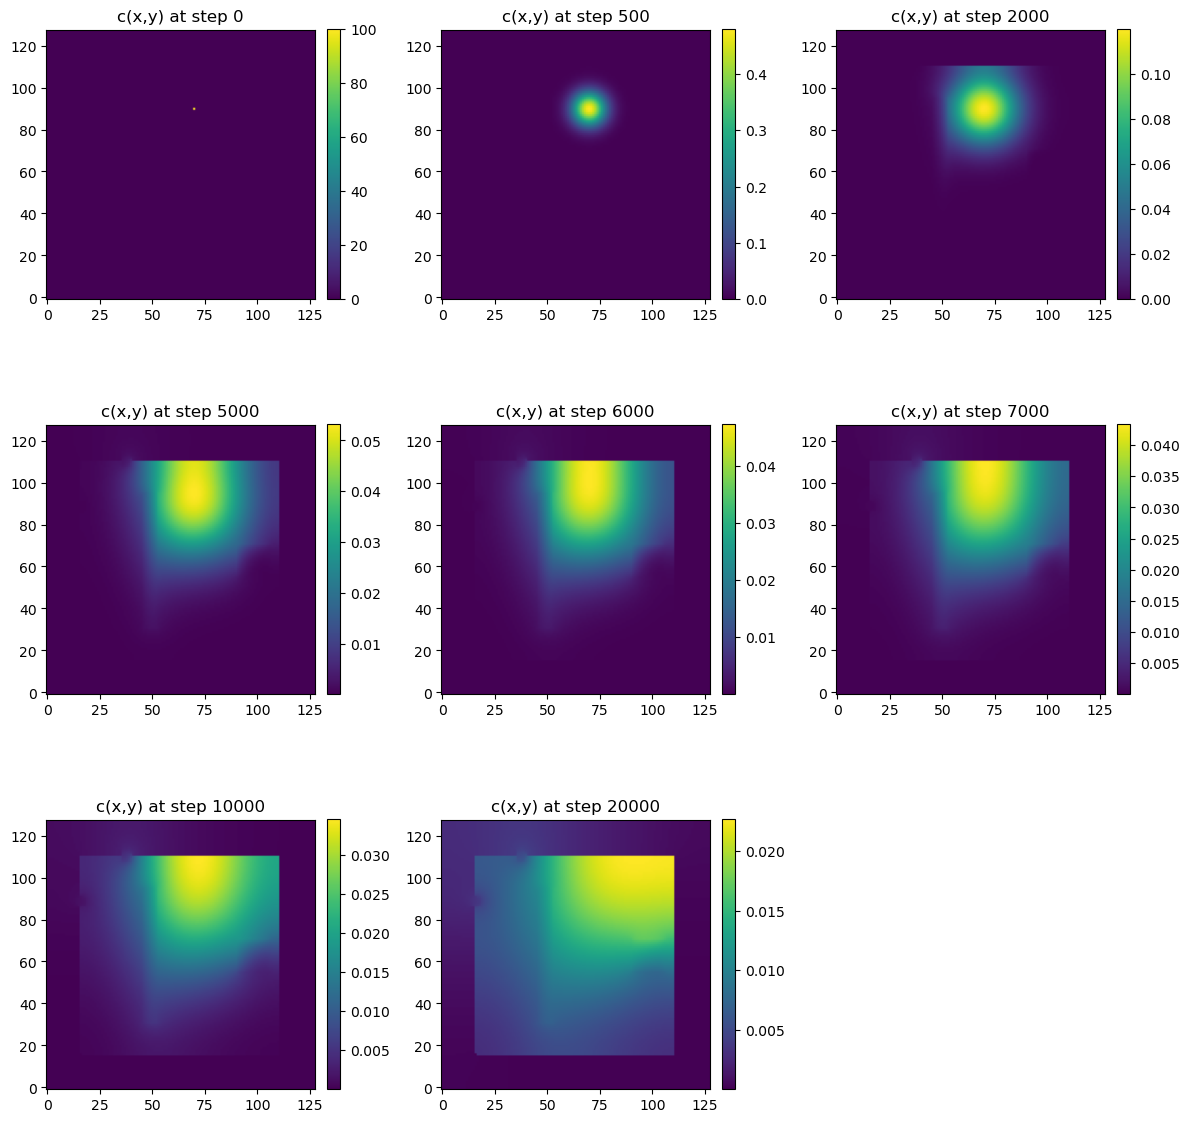

In [68]:
n = len(snaps)
ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
axs = axs.ravel()  # flatten to 1D for easy iteration

for ax, ((t, img), i) in zip(axs, zip(snaps.items(), range(n))):
    im = ax.imshow(img, origin="lower")
    ax.set_title(f"c(x,y) at step {t}")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Turn off any leftover empty axes
for j in range(n, nrows*ncols):
    axs[j].axis("off")

plt.tight_layout()
plt.show()

### Generate k-space

In [69]:
def to_kspace(S):
    # Forward 2D FFT, shifted so k=0 is in the center
    return np.fft.fftshift(np.fft.fft2(S))

def from_kspace(K):
    # Inverse FFT to reconstruct image
    return np.fft.ifft2(np.fft.ifftshift(K))

In [70]:
Kx_clean = to_kspace(Sx)
Ky_clean = to_kspace(Sy)

**Direct reconstruction to sanity check**

In [71]:
Sx_recon = from_kspace(Kx_clean)
Sy_recon = from_kspace(Ky_clean)

# they will be complex with tiny imaginary parts; take magnitude or real part
Sx_recon = np.abs(Sx_recon)
Sy_recon = np.abs(Sy_recon)

print("Max abs diff Sx:", np.abs(Sx - Sx_recon).max())
print("Max abs diff Sy:", np.abs(Sy - Sy_recon).max())

Max abs diff Sx: 4.440892098500626e-16
Max abs diff Sy: 4.440892098500626e-16


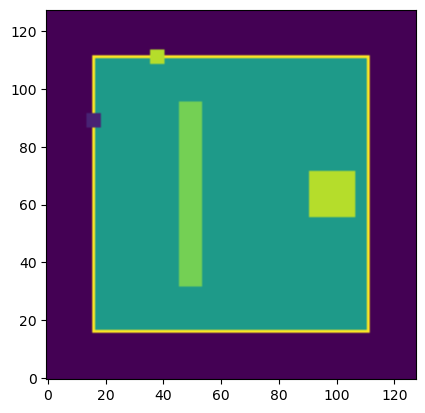

In [72]:
plt.imshow(Sx_recon, origin = "lower")

### Add noise for k-space

**random noise and filtering**

In [73]:
def add_kspace_noise(K_shifted, noise_level=0.05, rng=None):
    """
    Add complex Gaussian noise to k-space.
    
    Parameters
    ----------
    K_shifted : ndarray (complex)
        Shifted k-space (DC at center).
    noise_level : float
        Noise std as a fraction of max |K|.
        e.g. 0.05 -> 5% of max magnitude.
    rng : np.random.Generator or None
        Optional RNG for reproducibility.
    """
    if rng is None:
        rng = np.random.default_rng()

    amp_max = np.max(np.abs(K_shifted))
    sigma = noise_level * amp_max

    noise_real = rng.standard_normal(K_shifted.shape)
    noise_imag = rng.standard_normal(K_shifted.shape)

    noise = (sigma / np.sqrt(2)) * (noise_real + 1j * noise_imag)
    return K_shifted + noise

def add_kspace_spike(K_shifted, radius_fraction=0.6, amp_factor=5.0):
    """
    Add a single large spike at a high-frequency location in shifted k-space.

    Parameters
    ----------
    K_shifted : ndarray (complex)
        Shifted k-space (DC at center).
    radius_fraction : float
        Fraction of max radius where we place the spike (0..1).
        0.6 means 60% of the way from center to edge.
    amp_factor : float
        Spike amplitude as multiple of max |K|.
    """
    K_spike = K_shifted.copy()
    Ny, Nx = K_shifted.shape

    # Coordinates centered at zero
    ky, kx = np.mgrid[-Ny//2:Ny//2, -Nx//2:Nx//2]
    R = np.sqrt(kx**2 + ky**2)

    # target radius and pick any point near that radius
    R_max = R.max()
    target_R = radius_fraction * R_max

    mask_ring = np.logical_and(R >= target_R * 0.95,
                               R <= target_R * 1.05)

    ys, xs = np.where(mask_ring)
    if len(ys) == 0:
        return K_spike  # fallback

    # Pick one ring location (e.g. first)
    y_spike, x_spike = ys[0], xs[0]

    # Add a spike
    amp_max = np.max(np.abs(K_shifted))
    K_spike[y_spike, x_spike] += amp_factor * amp_max

    return K_spike

def gaussian_window(shape, sigma_fraction=0.25):
    """
    Build a 2D Gaussian window in k-space.

    Parameters
    ----------
    shape : tuple (Ny, Nx)
        Shape of k-space.
    sigma_fraction : float
        Sigma as fraction of half-size (in index units).
        e.g. 0.25 means sigma = 0.25 * (min(Ny,Nx)/2).
    """
    Ny, Nx = shape
    ky, kx = np.mgrid[-Ny//2:Ny//2, -Nx//2:Nx//2]

    # sigma in "index" units (0..Ny/2, 0..Nx/2)
    sigma = sigma_fraction * min(Ny, Nx) / 2.0
    r2 = (kx**2 + ky**2) / (sigma**2 + 1e-12)
    G = np.exp(-0.5 * r2)   # isotropic Gaussian
    return G

def hamming_window_2d(shape):
    """
    2D separable Hamming window: wy (rows) x wx (cols).
    """
    Ny, Nx = shape
    wx = np.hamming(Nx)
    wy = np.hamming(Ny)
    H = np.outer(wy, wx)
    return H

In [74]:
Kx_noisy = add_kspace_noise(Kx_clean, noise_level=0.005)

#Build filters
G = gaussian_window(Kx_clean.shape, sigma_fraction=0.35)
H = hamming_window_2d(Kx_clean.shape)

#Filter noisy k-space
Kx_gauss = Kx_noisy * G
Kx_hamm  = Kx_noisy * H

#Reconstruct images
Sx_noisy  = np.abs(from_kspace(Kx_noisy))
Sx_gauss  = np.abs(from_kspace(Kx_gauss))
Sx_hamm   = np.abs(from_kspace(Kx_hamm))

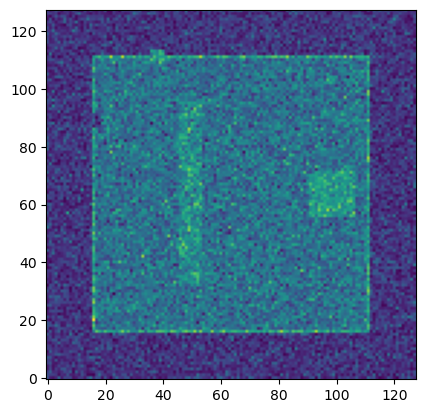

In [75]:
plt.imshow(Sx_noisy, origin = "lower")

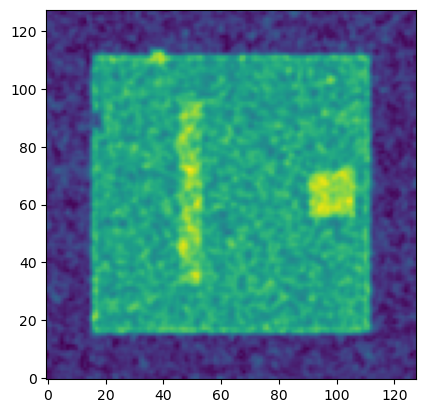

In [76]:
plt.imshow(Sx_gauss, origin = "lower")

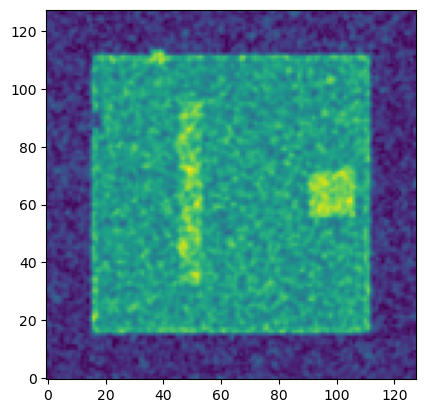

In [77]:
plt.imshow(Sx_hamm, origin = "lower")

**Real diffusion application**

In [78]:
c_5000 = snaps[20000]
Sx_5000 = c_5000 * np.exp(-b * D_eff_x)

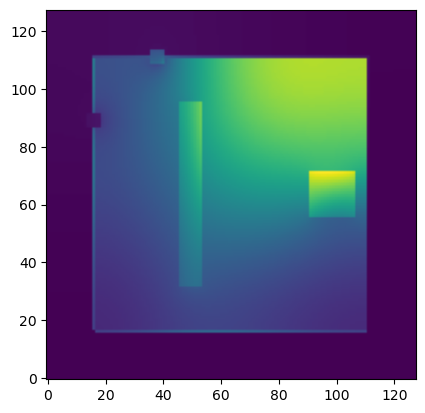

In [79]:
plt.imshow(Sx_5000, origin = "lower")

In [80]:
Kx_clean_5000 = to_kspace(Sx_5000)

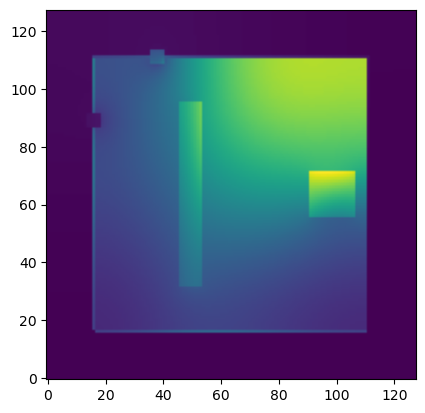

In [81]:
Sx_clean_5000_recon = from_kspace(Kx_clean_5000)
plt.imshow(np.abs(Sx_clean_5000_recon), origin = "lower")

In [103]:
K_noisy_5000 = add_kspace_noise(Kx_clean_5000, noise_level=0.01)

#Build filters
G = gaussian_window(Kx_clean_5000.shape, sigma_fraction=0.3)
H = hamming_window_2d(Kx_clean_5000.shape)

#Filter noisy k-space
K_gauss = K_noisy_5000 * G
K_hamm  = K_noisy_5000 * H

#Reconstruct images
S_noisy  = np.abs(from_kspace(K_noisy_5000))
S_gauss  = np.abs(from_kspace(K_gauss))
S_hamm   = np.abs(from_kspace(K_hamm))

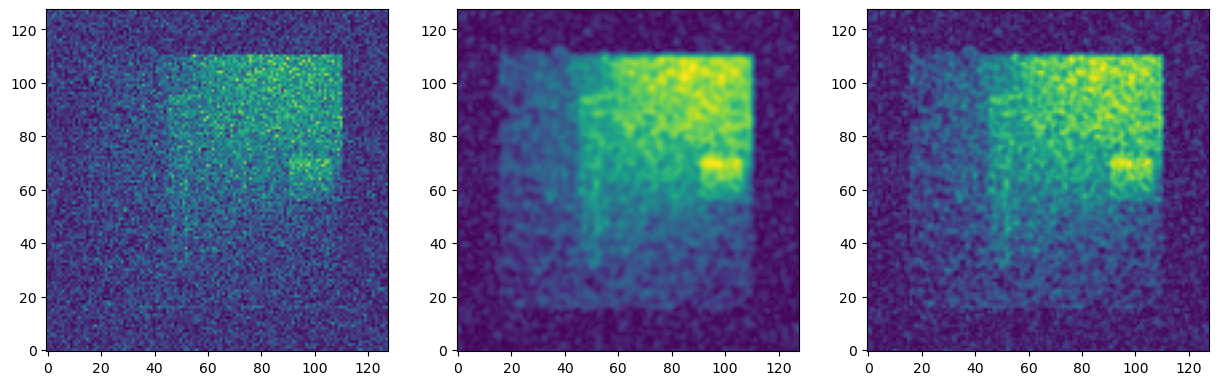

In [104]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(S_noisy, origin = "lower")

plt.subplot(1,3,2)
plt.imshow(S_gauss, origin = "lower")

plt.subplot(1,3,3)
plt.imshow(S_hamm, origin = "lower")

/tmp/ipykernel_6272/446029836.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


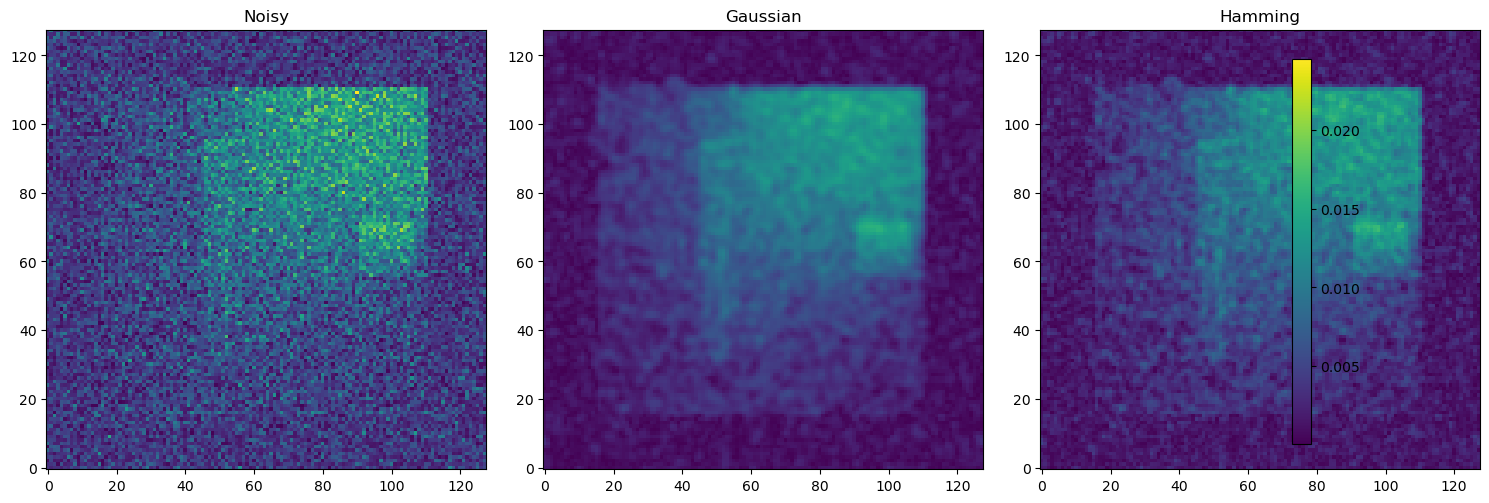

In [105]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1) Use common vmin/vmax across all three images
vmin = min(S_noisy.min(), S_gauss.min(), S_hamm.min())
vmax = max(S_noisy.max(), S_gauss.max(), S_hamm.max())

im0 = axes[0].imshow(S_noisy, origin="lower", vmin=vmin, vmax=vmax)
axes[0].set_title("Noisy")

im1 = axes[1].imshow(S_gauss, origin="lower", vmin=vmin, vmax=vmax)
axes[1].set_title("Gaussian")

im2 = axes[2].imshow(S_hamm, origin="lower", vmin=vmin, vmax=vmax)
axes[2].set_title("Hamming")

# 2) One shared colorbar for all axes
fig.colorbar(im0, ax=axes.ravel().tolist(), fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
